In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
import sys
sys.path.append('..')
from src.data import load_data,standardize

pd.set_option('precision',4)

# Unsupervised Data Mining
Unsupervised methods in data mining use machine learning algorithms to analyze and cluster unlabeled datasets (that is data without known target values). These algorithms discover hidden patterns or data groupings without the need for human intervention. The ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition.  Other unsupervised techniques include affinity analysis, which can be used to develop recommendation engines, and principal component analysis, used to reduce a number of predictors into the most valuable components.

And while unsupervised methods are useful by themselves, they can also provide interesting insights and add new factors that can be leveraged in supervised methods.

## Clustering
Clustering is a data mining technique which groups unlabeled data based on their similarities or differences. Clustering algorithms are used to process raw, unclassified data objects into groups represented by structures or patterns in the information. Clustering algorithms can be categorized into a few types, specifically exclusive, overlapping, hierarchical, and probabilistic.

### Exclusive and Overlapping Clustering
Exclusive clustering is a form of grouping that stipulates a data point can exist only in one cluster. This can also be referred to as “hard” clustering. The K-means clustering algorithm is an example of exclusive clustering.

> **K-means clustering** is a common example of an exclusive clustering method where data points are assigned into K groups, where K represents the number of clusters based on the distance from each group’s centroid. The data points closest to a given centroid will be clustered under the same category. A larger K value will be indicative of smaller groupings with more granularity whereas a smaller K value will have larger groupings and less granularity. K-means clustering is commonly used in market segmentation, document clustering, image segmentation, and image compression.

Overlapping clusters differs from exclusive clustering in that it allows data points to belong to multiple clusters with separate degrees of membership. “Soft” or fuzzy k-means clustering is an example of overlapping clustering.

### Hierachical Clustering
Hierarchical Clustering creates clusters in a hierarchical tree-like structure (also called a Dendrogram). Meaning, a subset of similar data is created in a tree-like structure in which the root node corresponds to entire data, and branches are created from the root node to form several clusters.

<style>
.center
{
    display:block;
    margin-left: auto;
    margin-right: auto;
    width: 50%;
}
</style>
<img src='../img/dendrogram.png' width=100 height=400 class='center'/>[image src][1]

[1]: https://www.mygreatlearning.com/blog/hierarchical-clustering/


## K-Means Clustering Example
One of the most common clustering algorithms is a K-means clustering.  `k` determines the number of clusters which provide "centroids" around which the observations are arranged.  Here are the steps in the learning

1. Intialization - initialize `k` random points to serve as the center (or centroid) of the clusters.
2. Cluster Assignment - for each observation, assign the record to the centroid to which it is closest.
3. Centroid Movement - once all the observations have been assigned, calculate the 'center' of each group.  This becomes the new centroid for the cluster.
4. Repeat Steps 2-3 until the centroids are not moving.

## Example Public Utilities
In our dataset we have a collection of public utilities in the United States.  We believe it would be helpful to study the impact of deregulation on utilities - but in order to do so we need to develop a cost-basis for a typical utility in each category.  Rather than build models for each utility individually we have been asked to find some similar utilities so that we can create more generalized model.



In [2]:
# Start by loading up our data
utils_df = load_data('Utilities', index_col='Company')
utils_df.head()

,Fixed_charge,RoR,Cost,Load_factor,Demand_growth,Sales,Nuclear,Fuel_Cost
Company,,,,,,,,
Arizona,1.06,9.2,151,54.4,1.6,9077,0.0,0.628
Boston,0.89,10.3,202,57.9,2.2,5088,25.3,1.555
Central,1.43,15.4,113,53.0,3.4,9212,0.0,1.058
Commonwealth,1.02,11.2,168,56.0,0.3,6423,34.3,0.700
NY,1.49,8.8,192,51.2,1.0,3300,15.6,2.044


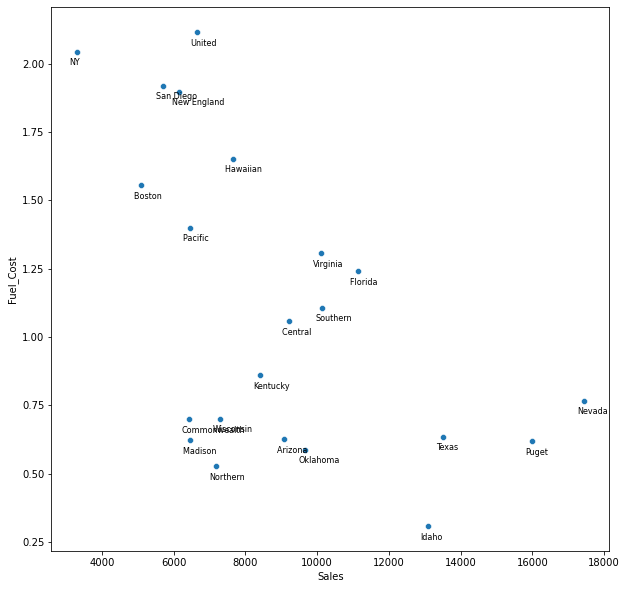

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=utils_df,x='Sales',y='Fuel_Cost')
for i in range(utils_df.shape[0]):
    plt.text(x=utils_df.Sales[i]-200,
        y=utils_df.Fuel_Cost[i]-0.05,
        s=utils_df.index[i],
        fontdict=dict(color='black',size=8))


We can see just from looking at the data here, that we have numbers that are all over the place in terms of scale.  Sales are in the thousands, while costs are in the single digits and the other values are somewhere in-between.  This is going to present a problem, the distance from a 'centroid' is going to be significantly impacted by sales while the other variables don't move it much at all.  Our first task then is to normalize the values.

Here's why, if we calculate the distance using Euclidean distance this is measured as 
$$distance = \sqrt{(x_{i1} - x_{j1})^2+(x_{i2} - x_{j2})^2 + .. (x_{ip} - x_{jp})^2}

In [26]:
# Standardize all the columns into a new dataframe
utils_df_std = standardize(utils_df, ['Fixed_charge', 'RoR', 'Cost', 'Load_factor','Demand_growth', 'Sales', 'Nuclear', 'Fuel_Cost'], drop_old=True )
utils_df_std

,Fixed_charge_STD,RoR_STD,Cost_STD,Load_factor_STD,Demand_growth_STD,Sales_STD,Nuclear_STD,Fuel_Cost_STD
Company,,,,,,,,
Arizona,-0.2932,-0.6846,-0.4171,-0.5777,-0.5262,0.0459,-0.7146,-0.8537
Boston,-1.2145,-0.1945,0.8210,0.2068,-0.3338,-1.0778,0.7920,0.8133
Central,1.7121,2.0782,-1.3396,-0.8915,0.0510,0.0839,-0.7146,-0.0804
Commonwealth,-0.5099,0.2066,-0.0044,-0.2191,-0.9431,-0.7017,1.3280,-0.7242
NY,2.0373,-0.8629,0.5782,-1.2950,-0.7186,-1.5814,0.2144,1.6926
Florida,1.1160,1.2315,-1.3882,0.6776,-1.7449,0.6234,0.6253,0.2486
Hawaiian,0.5740,0.6522,0.1655,2.3812,-0.3338,-0.3583,-0.7146,0.9877
Idaho,-0.0764,-0.6846,1.8649,0.0051,0.0190,1.1741,-0.7146,-1.4273
Kentucky,1.2244,1.0087,-0.0044,0.7672,1.2697,-0.1431,-0.7146,-0.4329


In [47]:
# Let's just cluster based on Sales and Fuel_Cost
X = utils_df_std[['Sales_STD','Fuel_Cost_STD']]

num_clusters=6
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

# Determine membership
members = pd.Series(kmeans.labels_, index=utils_df_std.index)
for k, v in members.groupby(members):
    print (f'{k} : '+", ".join(v.index))

0 : Central , Florida , Southern, Virginia
1 : Nevada, Puget
2 : Arizona , Commonwealth, Kentucky, Madison , Northern, Oklahoma, Wisconsin
3 : NY, New England, San Diego, United
4 : Boston , Hawaiian , Pacific 
5 : Idaho, Texas


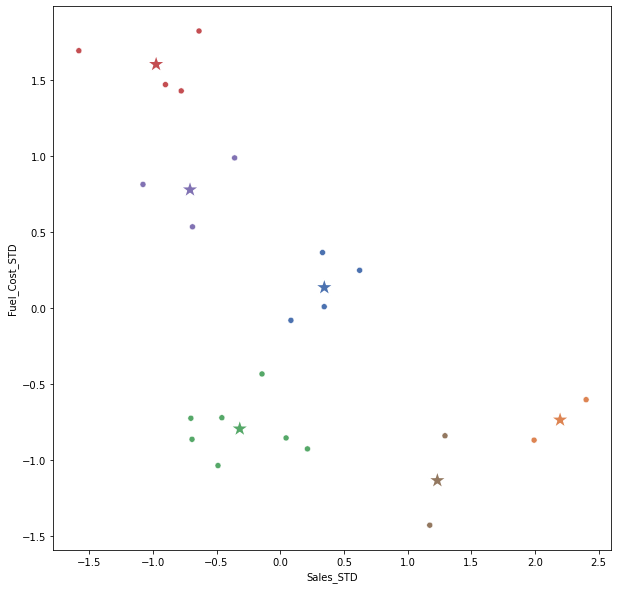

In [79]:
plt.figure(figsize=(10,10))
colors=['red', 'blue', 'purple', 'green', 'magenta', 'hotpink']
ax = sns.scatterplot(data=X,
    x='Sales_STD',
    y='Fuel_Cost_STD', 
    hue=kmeans.labels_, 
    palette="deep", 
    facecolors='none',
    legend=False)
ax = sns.scatterplot(x=kmeans.cluster_centers_[:, 0], 
    y=kmeans.cluster_centers_[:, 1], 
    hue=range(num_clusters), 
    palette="deep",
    marker="*",
    s=400,
    legend=False, ax=ax)



plt.show();                    

## Association Rules
An association rule is a rule-based method for finding relationships between variables in a given dataset. These methods are frequently used for market basket analysis, allowing companies to better understand relationships between different products. Understanding consumption habits of customers enables businesses to develop better cross-selling strategies and recommendation engines. Examples of this can be seen in Amazon’s “Customers Who Bought This Item Also Bought” or Spotify’s "Discover Weekly" playlist. While there are a few different algorithms used to generate association rules, such as Apriori, Eclat, and FP-Growth, the Apriori algorithm is most widely used.

### Apriori algorithms
Apriori algorithms have been popularized through market basket analyses, leading to different recommendation engines for music platforms and online retailers. They are used within transactional datasets to identify frequent itemsets, or collections of items, to identify the likelihood of consuming a product given the consumption of another product. For example, if I play Black Sabbath’s radio on Spotify, starting with their song “Orchid”, one of the other songs on this channel will likely be a Led Zeppelin song, such as “Over the Hills and Far Away.” This is based on my prior listening habits as well as the ones of others. Apriori algorithms use a hash tree to count itemsets, navigating through the dataset in a breadth-first manner.